#### Courbes de niveau

## Table des matières

- Préambule

  - Dépendances logicielles

  - Différentiation automatique

- Ensembles de niveau

  - Exemples de référence

  - Analyse des ensembles de niveau (Q1, Q2, Q3, Q4)

- Construction des courbes de niveau

  - Méthode de Newton (Q5, T1, T2)

  - Génération des points (Q6, T3)

  - Bouclage et auto-intersection (Q7, T4, T5)

- Post-traitement

  - Interpolation (Q8, T6)

  - Intégration (T7, T8)

## Préambule

### Dépendances logicielles 

In [3]:
# Python Standard Library
# -----------------------
pass

In [4]:
# Third-Party Libraries
# ---------------------

# Autograd & Numpy
import autograd
import autograd.numpy as np

# Pandas
import pandas as pd

# Matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 10] # [width, height] (inches). 

# Jupyter & IPython
from IPython.display import display

### Différentation automatique

On définit ici deux fonctions utilitaires, `grad` et `J`, permettant de calculer simplement le gradient d'une fonction scalaire de deux variables réelles et la matrice jacobienne d'une fonction vectorielle de deux variables réelles.

In [5]:
def grad(f):
    g = autograd.grad
    def grad_f(x, y):
        return np.array([g(f, 0)(x, y), g(f, 1)(x, y)])
    return grad_f

In [6]:
def J(f):
    j = autograd.jacobian
    def J_f(x, y):
        return np.array([j(f, 0)(x, y), j(f, 1)(x, y)]).T
    return J_f

#### Exemples d'usage

In [7]:
def f(x, y):
    return np.sin(x) + 2.0 * np.sin(y)

grad_f = grad(f)

grad_f(0.0, 0.0) # array([1., 2.])

array([1., 2.])

In [8]:
def f(x, y):
    return np.array([x + 2 * y, 3 * x + 4 * y])

J_f = J(f)

J_f(0.0, 0.0) # array([[1., 2.], [3., 4.]])

array([[1., 2.],
       [3., 4.]])

#### Précautions

Les deux sources d'erreurs (avec messages cryptiques) les plus communes avec autograd :

**Selection de NumPy**

N'importez pas NumPy directement, par exemple avec

    >>> import numpy as np # Wrong !

mais importez le module `numpy` qui a été modifié par `autograd` (pour que les fonctions du module "coopérent" avec les algorithmes de différentiation automatique). 

    >>> import autograd.numpy as np # Right !
    
Utilisez-le ensuite comme vous le feriez avec NumPy classique.

**Utilisez des doubles**

Les fonctions générées par autograd sont strictes quand au type des nombres utilisés (plus strictes que les fonctions NumPy) : il doit s'agir de doubles. Par exemple, si l'on définit

    >>> def add(x, y):
    ...    return x + y
    >>> grad_add = grad(add)

Alors `grad_add(0.0, 0.0)` renvoie `array([1.0, 1.0])`, mais `grad_add(0, 0)` génère une erreur, car ses arguments sont des entiers et non des doubles.


## Ensembles de niveau

On appelle *ensemble de niveau* $c \in \mathbb{R}$ d'une fonction $f : \mathbb{R}^2 \to \mathbb{R}$  l'ensemble du plan
$$
\{(x_1,x_2) \in \mathbb{R}^2 \; | \; f(x_1, x_2) = c\}.
$$


### Exemples de référence

On définit ici quelques fonctions qui pourront servir de référence pour valider les algorithmes de génération de courbes de niveau. On pourra également utiliser la fonction utilitaire `display_contour` ci-dessous, qui exploite [la fonction `contour` de Matplotlib](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.contour.html) pour représenter une collection d'ensembles de niveau.

In [9]:
def display_contour(f, x, y, levels):
    X, Y = np.meshgrid(x, y)
    Z = f(X, Y)
    fig, ax = plt.subplots()
    contour_set = plt.contour(
        X, Y, Z, colors="grey", linestyles="dashed", 
        levels=levels 
    )
    ax.clabel(contour_set)
    plt.grid(True)
    plt.xlabel("$x_1$") 
    plt.ylabel("$x_2$")
    plt.gca().set_aspect("equal")

#### Fonction quadratique

In [10]:
def f1(x1, x2):
    x1 = np.array(x1)
    x2 = np.array(x2)
    return 3.0 * x1 * x1 - 2.0 * x1 * x2 + 3.0 * x2 * x2 

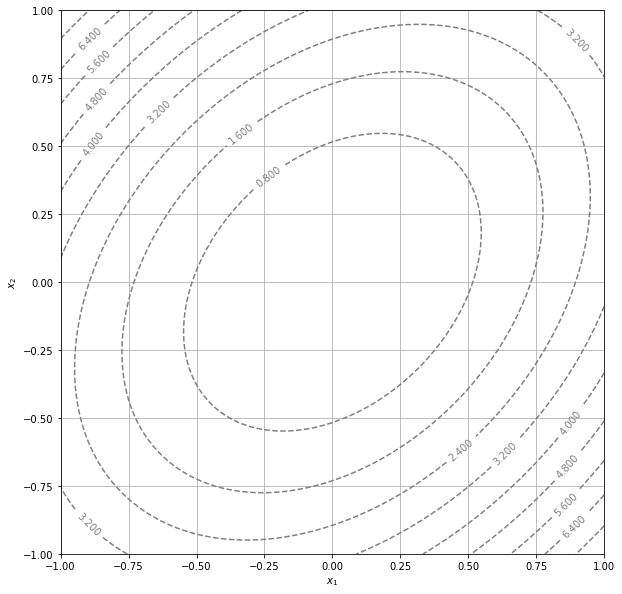

In [11]:
display_contour(
    f1, 
    x=np.linspace(-1.0, 1.0, 100), 
    y=np.linspace(-1.0, 1.0, 100), 
    levels=10 # 10 levels, automatically selected
)

#### Fonction de Rosenbrock

Source : [Fonction de Rosenbrock, Wikipédia](https://en.wikipedia.org/wiki/Rosenbrock_function)

$$
f_2 : (x_1,x_2) \in \mathbb{R}^2 \mapsto (x_1 - 1)^2 + (x_1 - x_2^2)^2
$$

In [12]:
def f2(x1, x2):
    return (x1 - 1)**2 + (x1 - x2**2)**2

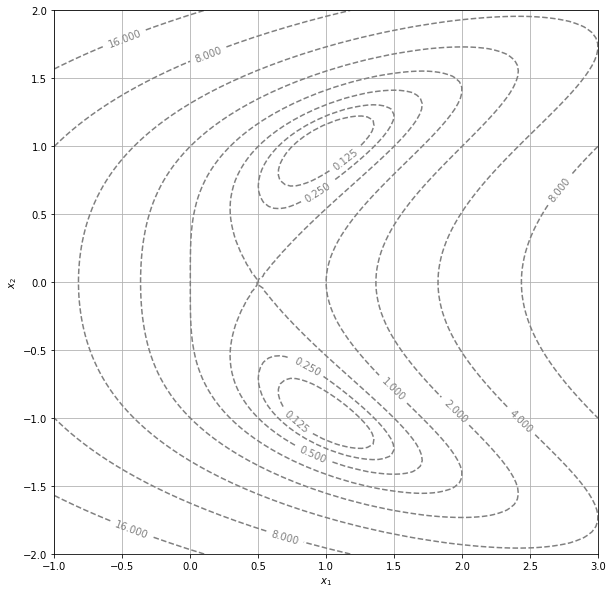

In [13]:
display_contour(
    f2, 
    x=np.linspace(-1.0, 3.0, 100), 
    y=np.linspace(-2.0, 2.0, 100), 
    levels=[2**i for i in range(-3, 8)] # levels: [0.125, 0.25, ..., 64, 128]
)

#### Fonction complexe

Source: [Courbe implicite, Wikipédia](https://en.wikipedia.org/wiki/Implicit_curve)

In [14]:
def f3(x, y):
    return np.sin(x + y) - np.cos(x * y) - 1 + 0.001 * (x * x + y * y) 

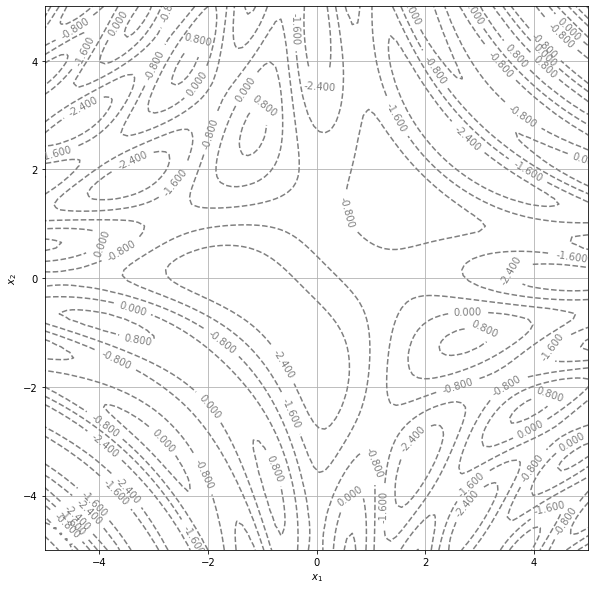

In [15]:
display_contour(
    f3, 
    x=np.linspace(-5.0, 5.0, 100), 
    y=np.linspace(-5.0, 5.0, 100), 
    levels=5, # 5 levels, automatically selected
)

### Analyse des ensembles de niveau

#### Question 1

Soit $c \in \mathbb{R}$.
On suppose que la fonction $f:\mathbb{R}^2 \to \mathbb{R}$ est continue et vérifie
$f(x_1, x_2) \to +\infty$ quand $\|(x_1,x_2)\| \to +\infty$.
Que peut-on dire de l'ensemble de niveau $c$ de $f$ ?

Dans la suite la fonction $f$ est supposée continûment différentiable. On suppose également que le gradient $\nabla f$ ne s'annule pas dans un voisinage du point $x_0 = (x_{10}, x_{20}) \in \mathbb{R}^2$. On pose alors
$$
p(x_1, x_2) := \frac{\partial_2 f(x_0)}{\|\nabla f(x_0)\|} (x_1 - x_{10}) -
\frac{\partial_1 f(x_0)}{\|\nabla f(x_0)\|} (x_2 - x_{20}).
$$

#### **Réponse :**

Notons $C = \{(x_1,x_2) | f(x_1,x_2) = c\}$

- $C = f^{-1} (\{c\})$, c'est-à-dire que $C$ est l'ensemble des images réciproques de $\{c\}$, qui est un fermé de $\mathbb{R}$, par la fonction $f$ continue sur $\mathbb{R}^2$. 

Donc, d'après le critère de l'image réciproque, $C$ est un fermé de $\mathbb{R}^2$.

- De plus, $f(x_1,x_2) \to +\infty$ quand $\|(x_1,x_2)\| \to +\infty$  
Donc pour tout A $\in \mathbb{R}$, il existe $M \in \mathbb{R^*}$ tel que $\forall (x_1,x_2) \in \mathbb{R}, \|(x_1,x_2)\| \ge M => f(x_1,x_2) \ge A$.   
Donc, pour $c \in \mathbb{R}$, il existe $M_{c} \in \mathbb{R^*}$ tel que $\forall (x_1,x_2) \in \mathbb{R}, \|(x_1,x_2)\| \ge M_{c} => f(x_1,x_2) \ge c$.  
Ou encore, $\forall (x_1,x_2) \in \mathbb{R}, f(x_1,x_2) \le c => \|(x_1,x_2)\| \le M_{c}$.   
Donc $M_{c}$ est un majorant des éléments de $C$. Donc $C$ est borné.  

__Conclusion__ : $C$ est borné et fermé, c'est donc un compact de $\mathbb{R^2}$. 

#### Question 2
Comment interpréter géométriquement le terme $p(x_1,x_2)$ ?

#### **Réponse :**

Au point $x_{0}$, le gradient de $f$ s'écrit $\nabla f(x_0) = (\partial_1 f(x_0) , \partial_2 f(x_0))$.   
On peut donc voir que : 

$$
\forall x = (x_1,x_2) \in \mathbb{R^2},
\begin{vmatrix}\frac{\nabla f(x_0)}{\|\nabla f(x_0)\|} & x - x_0  
\end{vmatrix}
= 
\frac{1}{\|\nabla f(x_0)\|} 
\begin{vmatrix}\partial_1 f(x_0) & x_1 - x_{10}\\
\partial_2 f(x_0) & x_2-x_{20}
\end{vmatrix}
=
-p(x_1,x_2)
$$

Ainsi, $p(x_1,x_2)$ représente l'opposé de l'aire du parallèlogramme engendré par les vecteurs $\frac{\nabla f(x_0)}{\|\nabla f(x_0)}$ et $x-x_0$.

#### Question 3

Montrer que dans un voisinage ouvert de $x_0$, on peut paramétriser l'ensemble de niveau $c:=f(x_0)$ au moyen de $p(x_1,x_2),$ c'est-à-dire qu'il existe un $\varepsilon > 0$ et une fonction (continûment différentiable) $\gamma :\left]-\varepsilon,\varepsilon \right[ \to \mathbb{R}^2$ tels que dans un voisinage ouvert de $x_0,$ $f(x_1,x_2) = c$ si et seulement si $(x_1, x_2) = \gamma(t)$ où $t = p(x_1, x_2)$.

#### **Réponse :**

Considérons la fonction $g : \mathbb{R^2}\times\mathbb{R} \to \mathbb{R^2}$ telle que $\forall (x,t) \in \mathbb{R^2}\times\mathbb{R}, g(x,t) = (f(x) - c, p(x) - t)$. On notera $x = (x1,x2) \in \mathbb{R^2}$

- $f$ et $p$ sont continûment différentiables sur $\mathbb{R^2}$.   
$t \in \mathbb{R} \to -t$ est de classe $C^1$ sur $\mathbb{R}$.   
Donc **g est continûment différentiable** sur $\mathbb{R^2}\times\mathbb{R}$.

- $g(x_0, 0) = (f(x_0) - c, p(x_0)) = 0$ car $p(x_0) = 0$ et $f(x_0) = c$ par définition. 

- Calculons $\partial_x g(x,t)$ en un point $(x,t)$ quelconque.
On s'intéresse à la dérivée partielle par rapport à $x$, qui est un vecteur de $\mathbb{R^2}$. Cela revient à prendre les deux premières colonnes de la matrice jacobienne de $g$, c'est-à-dire:
$$ \forall (x,t) \in \mathbb{R^2}\times\mathbb{R}, \partial_x g(x,t) = \begin{bmatrix}\partial_1 (f(x_1,x_2) -c) & \partial_2 (f(x_1,x_2) -c)
\\ \partial_1 (p(x_1,x_2) - t) & \partial_2(p(x_1,x_2) - t)
\end{bmatrix}   
= \begin{bmatrix}\partial_1 f(x_1,x_2) & \partial_2 f(x_1,x_2)
\\ \partial_1 p(x_1,x_2) & \partial_2 p(x_1,x_2)
\end{bmatrix}$$
Le déterminant de cette matrice en $x_0$ vaut 
$$det = \partial_1 f(x_0) \partial_2 p(x_0) - \partial_1 p(x_0) \partial_2 f(x_0) 
= \frac{1}{\|\nabla f(x_0)\|}  (-(\partial_1 f(x_0))^2 - (\partial_2 f(x_0))^2) = -1$$

Or, la fonction déterminant est continue, donc on peut trouver un voisinage *U* de $x_0$ tel que la déterminant ne s'annule pas sur ce voisinage. On en déduit que **$\partial_x g$ est inversible sur $U\times\mathbb{R}$.**

On peut alors appliquer le Théorème des fonctions implicites à la fonction *g* autour du point $(x_0, 0)$, en lequel la fonction s'annule - en se restreignant à $U\times\mathbb{R}$ - et donc :   
Il existe des voisinages ouverts $V$ de $x_0$ et $W$ de $t=0$, ainsi qu'une unique fonction implicite $\gamma : 
- W \to \mathbb{R^2}$ tel que $\forall (x,t) \in V \times W , g(x,t) = 0 <=> x = \gamma(t)$. $W$ est un voisinage ouvert de $t=0$, il est donc bien de la forme $]-\varepsilon, \varepsilon[$ où $\varepsilon \in \mathbb{R^*_+}$.
- Par définition de $g$, l'équivalence se réécrit : $\forall (x,t) \in V \times W, f(x) = c <=> x = \gamma(t)$, où $t = p(x)$. 

On a donc bien le résultat demandé.  

#### Question 4

Montrer que pour tout $t \in \left]-\varepsilon, \varepsilon \right[$ :

  - le vecteur $\gamma'(t)$ est non nul (il fournit donc une tangente au chemin $\gamma$),

  - est orthogonal à $\nabla f(\gamma(t))$.
  
**Réponse :**

- $\forall t \in ]-\varepsilon , \varepsilon[, p(y(t)) = t$. Or, $p$ est différentiable sur $\mathbb{R^2}$ et $\gamma$ est dérivable sur  $]-\varepsilon , \varepsilon[$. On peut donc appliquer la règle de différentiation en chaîne, ce qui donne :
$\forall t \in ]-\varepsilon , \varepsilon[, dp(\gamma(t)).\gamma'(t) = 1$. 
On en déduit que $\gamma$ **ne peut s'annuler sur l'ouvert** $]-\varepsilon , \varepsilon[$.

- $\forall t \in ]-\varepsilon , \varepsilon[, f(\gamma(t)) = c$ d'après la question précédente.   
Donc en différentiant la relation, on a :
$d(fo\gamma)(t) = d(c) = 0$.   
Or, 
$$
\forall t \in ]-\varepsilon , \varepsilon[, d(fo\gamma)(t) = df(\gamma(t)).\gamma'(t) = \ <\nabla f(\gamma(t) \ ,\ \gamma'(t)> = 0.$$

## Construction des courbes de niveau

### Méthode de Newton

Afin de trouver des points sur des courbes de niveau, on souhaite implémenter un algorithme de résolution des équations de la forme $F(x) = 0$ où $F: \mathbb{R}^2 \to \mathbb{R}^2$, par la méthode de Newton, amorcée par un point de référence $x_0 \in \mathbb{R}^2$.

L'implémentation prendra la forme générale donnée ci-dessous. L'appel `x, y = Newton(F, x0, y0, eps, N)` devra renvoyer le couple des coordonnées d'un point $(x, y)$ qui est une solution approchée de $F(x,y)=0$ à proximité de $(x_0, y_0)$. La qualité de l'approximation produite est déterminée par le réel positif $\varepsilon > 0$, une approximation de la distance entre le point $(x,y)$ renvoyé par la fonction et la solution exacte. L'algorithme itératif s'interrompra si aucune approximation de la précision souhaitée n'a été trouvée en $N$ étapes. 

#### Question 5

L'application à laquelle nous destinons la fonction `Newton` demande-t'elle une grande précision ?
Choisir une valeur de `eps` qui semble raisonnable et justifier l'ordre de grandeur choisi.

In [42]:
N = 100
eps = 0.01

#### Tâche 1

Implémenter la fonction `Newton` en complétant le canevas ci-dessous

In [43]:
# Nous avons ajouté un booléen "plot" qui sert pour l'affichage (Tache 2)

def Newton(F, x0, y0, eps=eps, N=N, plot=False):
    x, y = x0, y0
    J_F = J(F)
    X0, Y0 = [x0], [y0]
    for i in range(N):
        
        # Implémentation de l'algorithme de Newton :
        x, y = np.array([x, y]) - np.dot(np.linalg.inv(J_F(x,y)), F(x,y))                                    
        X0.append(x)
        Y0.append(y)
        if np.sqrt((x - x0)**2 + (y - y0)**2) <= eps:
            
            # Affichage
            if plot:
                display_contour(f1, x=np.linspace(-1.0, 1.0, 100), 
                                    y=np.linspace(-1.0, 1.0, 100), levels=10)
                plt.title(f'Initial : ({X0[0]:.3f},{Y0[0]:.3f})      Final : ({X0[-1]:.3f},{Y0[-1]:.3f})', fontsize=10)
                plt.scatter(np.array(X0), np.array(Y0), label = 'Algorithme de Newton')
                # Point de depart en vert
                plt.scatter(np.array(X0[0]), np.array(Y0[0]), color = 'green')
                # Point d'arrivee en rouge
                plt.scatter(np.array(X0[-1]), np.array(Y0[-1]), color = 'red')       
                plt.legend()
                          
            return x, y
        x0, y0 = x, y
    else:
        raise ValueError(f"no convergence in {N} steps.")

#### Tâche 2

Testez votre implémentation de la fonction `Newton` ! On suggère par exemple de l'utiliser pour chercher un point $(x_1, x_2)$ de la ligne de niveau $0.8$ de $f_1$ (cf. Exemples de référence) qui vérifie en outre $x_1 = x_2$ en utilisant le point initial $(0.8, 0.8)$. Puis de faire varier le point initial, la contrainte supplémentaire, etc. et de représenter graphiquement les résultats.

(0.28680960827532986, 0.5355763476341256)
(0.18187692686901658, -0.4264777014840448)


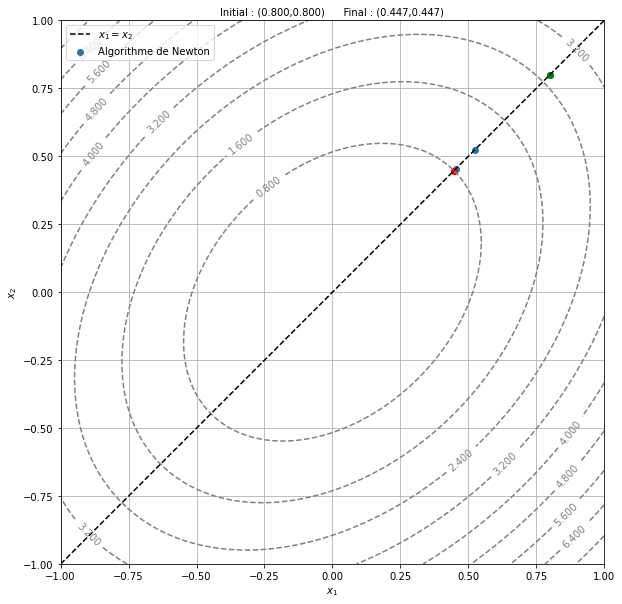

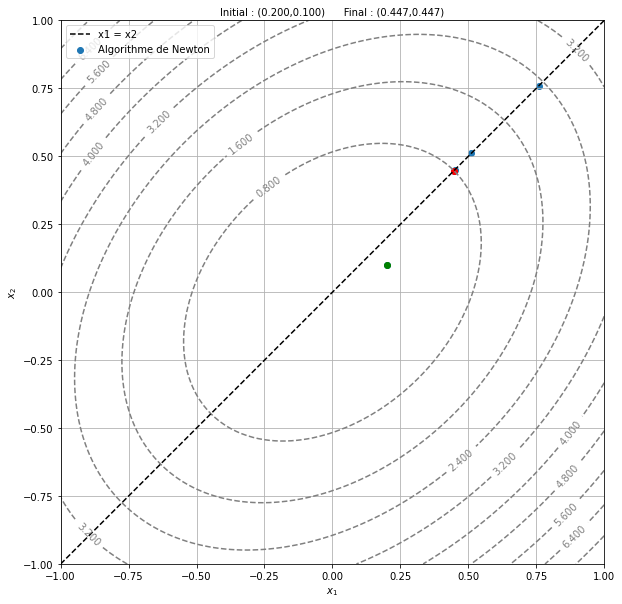

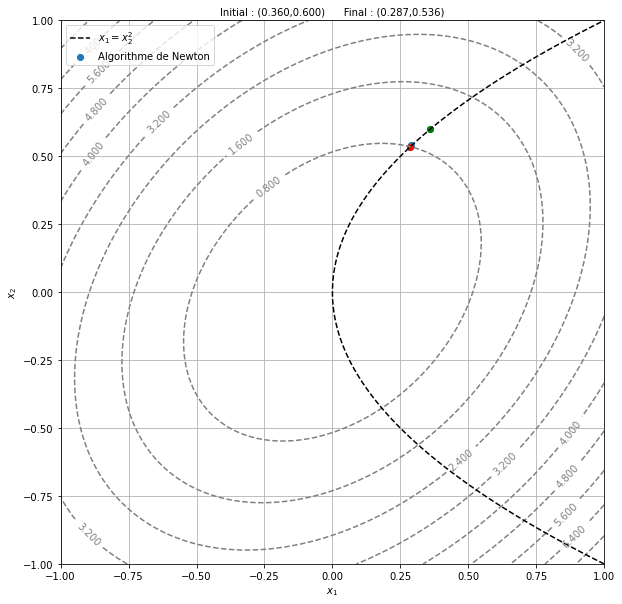

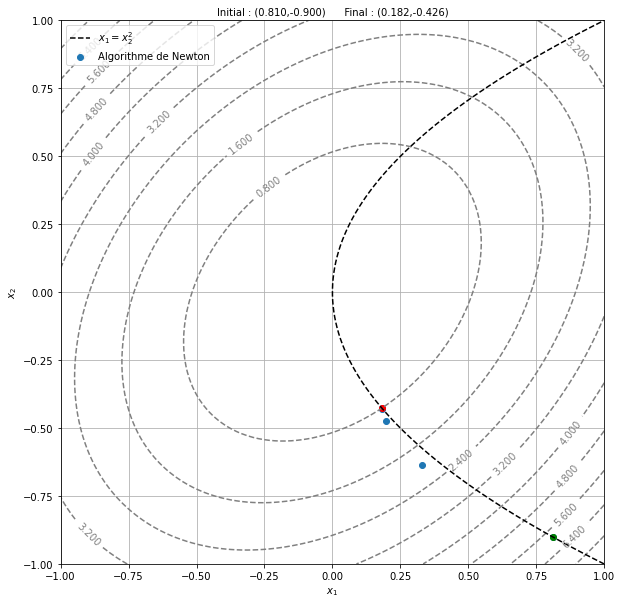

In [44]:
def rep_resultats(f1, eps, N):
    
    # Cas lineaire : x1 = x2
    def F(x, y):
        return np.array([f1(x, y) - 0.8, y - x])
    t = np.linspace(-1, 1, 100)
    Newton(F, 0.8, 0.8, eps, N, True)
    plt.plot(t, t, '--', label='$x_1 = x_2$', color='black')
    plt.legend()
    Newton(F, 0.2, 0.1, eps, N, True)
    plt.plot(t, t, '--', label='x1 = x2', color='black')
    plt.legend()
    
    # Cas quadratique : x1 = x2^2
    def F(x, y):
        return np.array([f1(x, y) - 0.8, y**2 - x])
    print(Newton(F, 0.36, 0.6, eps, N, True))
    plt.plot(t*t, t, '--', label='$x_1 = x_2^2$', color='black')
    plt.legend()
    print(Newton(F, 0.81, -0.9, eps, N, True))
    plt.plot(t*t, t, '--', label='$x_1 = x_2^2$', color='black')
    plt.legend()
    
rep_resultats(f1, eps, N)

### Génération des points

#### Question 6 + Tâche 3
Comment, en partant d'un point de référence $(x_0, y_0)$ tel que $f(x_0, y_0)=c$, peut-on générer avec la méthode de Newton un point $(x_1, y_1)$ également tel que $f(x_1, y_1) = c$, mais à une distance $\delta > 0$ de $(x_0, y_0)$ et qui soit "à droite" quand on est en $(x_0, y_0)$ et qu'on regarde dans la direction de $\nabla f(x_0, y_0)$ ? Implémenter la fonction `level_curve` qui répète ce procédé $N-1$ fois et renvoie un tableau NumPy de taille `(2, N)` contenant les coordonnées des points correspondants, puis valider graphiquement le résultat au moyen des exemples de référence.

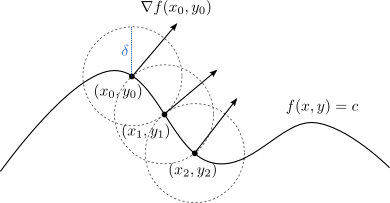

**Réponse :**

Pour trouver $(x_1,y_1)$ à droite de $\nabla f(x_0,y_0)$ tel que $f(x_1,y_1) = c$, on peut implémenter l'algorithme de Newton sur le cercle $C_0$ de rayon $\delta$ et de centre $(x_0,y_0)$. Le point initial est choisi de sorte que $(x_1,y_1)$ soit bien à droite du gradient, on choisira donc de lancer l'algorithme en partant du point $(x_{1}', y_{1}')$ situé sur le cercle $C_0$, tel que l'angle entre les vecteurs $(x_1' - x_0, y_1' - y_0)$ et $\nabla f(x_0,y_0)$ soit de $+ \frac{\pi}{2}$. Ainsi, si on choisit $\delta$ suffisamment petit, on obtiendra un unique point $(x_1,y_1)$, en supposant la fonction suffisamment régulière au voisinage du point $(x_0,y_0)$.  

In [45]:
def level_curve(f, x0, y0, delta=0.1, N=1000, eps=eps):
    c = f(x0, y0)
    # X : ensemble des abscisses, Y : ensemble des ordonnées
    X, Y = [], []
    grad_f = grad(f)

    x, y = x0, y0
    for i in range(N):
        # Méthode de Newton selon le cercle de centre (x,y) et de rayon delta
        def F(x1, y1):
            return np.array([f(x1, y1) - c, (x1 - x)**2 + (y1 - y)**2 - delta**2])
        X.append(x)
        Y.append(y)
        # direction est le vecteur unitaire de grad_f (meme sens et direction)
        direction = 1/np.linalg.norm(grad_f(x, y)) * grad_f(x, y)
        x1, y1 = x + delta*direction[1], y - delta*direction[0]
        x, y = Newton(F, x1, y1, eps, N)

    return np.array(X), np.array(Y)

ValueError: no convergence in 1000 steps.

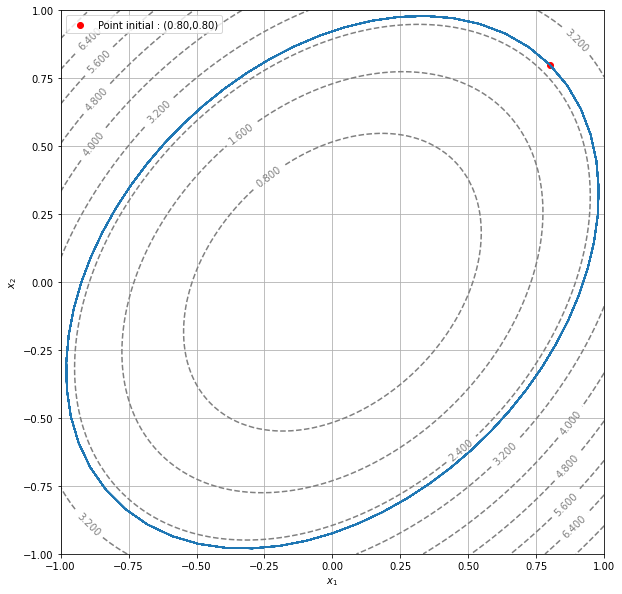

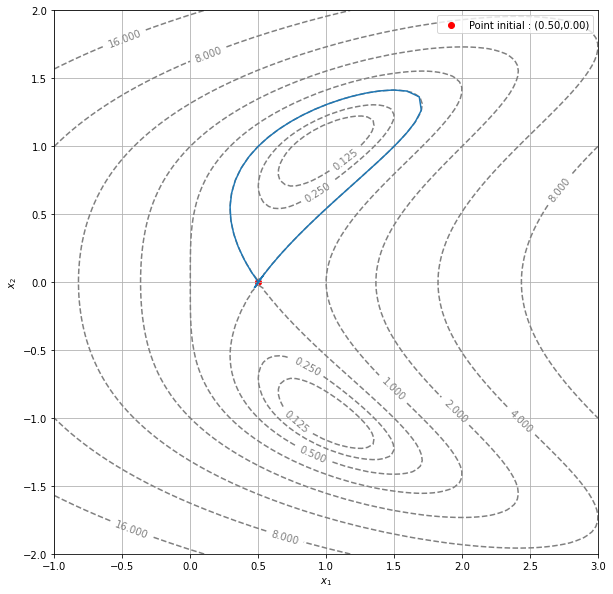

In [46]:
def test_tache3(f1, f2, f3, eps):

    Z1 = level_curve(f1, 0.8, 0.8, 0.1, 1000, eps)
    display_contour(f1, x=np.linspace(-1.0, 1.0, 100), y=np.linspace(-1.0, 1.0, 100), levels=10)
    plt.scatter(np.array(Z1[0][0]), np.array(Z1[1][0]), color = 'red', label = f'Point initial : ({Z1[0][0]:.2f},{Z1[1][0]:.2f})')
    plt.plot(Z1[0], Z1[1])
    plt.legend()

    Z2 = level_curve(f2, 0.5, 0.001, 0.1, 1000, eps)
    display_contour(f2, x=np.linspace(-1.0, 3.0, 100), y=np.linspace(-2.0, 2.0, 100), levels=[2**i for i in range(-3, 8)])
    plt.scatter(np.array(Z2[0][0]), np.array(Z2[1][0]), color = 'red', label = f'Point initial : ({Z2[0][0]:.2f},{Z2[1][0]:.2f})')
    plt.plot(Z2[0], Z2[1])
    plt.legend()
    
    Z3 = level_curve(f3, 1.9, 0.5, 0.1, 1000, eps)
    display_contour(f3, x=np.linspace(-5.0, 5.0, 100), y=np.linspace(-5.0, 5.0, 100), levels=5)
    plt.scatter(np.array(Z3[0][0]), np.array(Z3[1][0]), color = 'red', label = f'Point initial : ({Z3[0][0]:.2f},{Z3[1][0]:.2f})')
    plt.plot(Z3[0], Z3[1])
    plt.legend()

test_tache3(f1, f2, f3, eps)

### Bouclage et auto-intersection

L'algorithme précédent est malheureusement susceptible de faire plusieurs fois le tour d'une courbe de niveau donnée. 

#### Question 7 + Tâche 4

Proposer une nouvelle implémentation de `level_curve` qui arrête l'algorithme et renvoie les points connus quand le segment formé par les deux derniers points produits intersecte l'un des segments produits auparavant. En étant (raisonnablement) optimiste, doit-t'on prendre la peine de tester l'intersection du dernier segment avec tous les segments déjà produits (ce qui prend du temps ...) ou juste avec le premier ? Pour répondre à cette question, on pourra se demander si les courbes de niveau similaires à celle de la fonction de Rosenbrock passant par le point $(0.5, 0)$ (cf. Exemples de référence) -- c'est-à-dire "auto-intersectantes" -- sont fréquentes ou rares et pourquoi.

**Réponse :**

La comparaison avec le premier segment est peu risquée, car les courbes de niveau "auto-intersectantes" sont rares. Prenons l'exemple de la fonction de Rosenbrock. En annulant les dérivées partielles, on constate que l'ensemble des points critiques est $\{(0.5, 0) ; (1, -1) ; (1,1) \}$. En particulier, le point $(0.5,0)$ n'est pas un extremum, c'est un col.   
De façon plus générale, les courbes auto-intersectantes se coupent en un col, et l'ensmble des cols est au plus dénombrable, donc négligeable.

In [47]:
def intersection(s0, s1):
    """
    L'algorithme vérifie si deux segments se coupent de la manière suivante :
    1) Il détermine les droites engendrées par les deux segments
    2) Il trouve le point d'intersection de ces droites (s'il existe)
    3) Il vérifie que ce point est bien compris dans les deux segments.
    """
    x00, y00 = s0[0]            # On note les segments s_i = ((xi0,yi0),(xi1,yi1))
    x01, y01 = s0[1]
    x10, y10 = s1[0]
    x11, y11 = s1[1]
    a0 = (y01 - y00)/(x01-x00)  # On note les droites engendrées par les segments s_i sous la forme y = ai*x + bi
    b0 = y00 - a0*x00
    a1 = (y11 - y10)/(x11-x10)
    b1 = y10 - a1*x10
    if a0 != a1:                # On verifie que les deux droites ne sont pas parralleles
        x = (b0 - b1)/(a1 - a0)     # Le point d'intersection des deux droites
        return(x00 <= x <= x01 or x01 <= x <= x00) and (x10 <= x <= x11 or x11 <= x <= x10)
    elif a0 == a1 and b0 == b1:
        return not (np.max(x00,x01) < np.min(x10,x11) or np.max(x10,x11) < np.min(x00,x01))
    else:
        return False

In [48]:
def level_curve_bis(f, x0, y0, delta=0.1, N=1000, eps=eps):
    c = f(x0, y0)
    grad_f = grad(f)
    
    # Initiaisation (construction du premier segment)
    def F(x, y):
            return np.array([f(x, y) - c, (x - x0)**2 + (y - y0)**2 - delta**2])
    direction = 1/np.linalg.norm(grad_f(x0, y0))*grad_f(x0, y0)
    xi, yi = x0 + delta*direction[1], y0 - delta*direction[0]
    x1, y1 = Newton(F, xi, yi, eps, N)
    s0 = [[x0,y0], [x1,y1]]
    x, y = x1, y1
    X, Y = [x0,x1], [y0,y1]

    for i in range(N-1):
        def F(xi, yi):
            return np.array([f(xi, yi) - c, (xi - x)**2 + (yi - y)**2 - delta**2])
        direction = 1/np.linalg.norm(grad_f(x, y))*grad_f(x, y)
        xi, yi = x + delta*direction[1], y - delta*direction[0]
        xf, yf = Newton(F, xi, yi, eps, N)
        X.append(xf)
        Y.append(yf)
        # Contrairement à l'algorithme précédent, on doit considérer le dernier segment
        s1 = [[x,y], [xf,yf]]
        # Et vérifier s'il coupe le premier
        if intersection(s0, s1):
            return np.array(X), np.array(Y)
        x, y = xf, yf
    return np.array(X), np.array(Y)


#### Tâche 5

Valider graphiquement le résultat au moyen des exemples de référence.

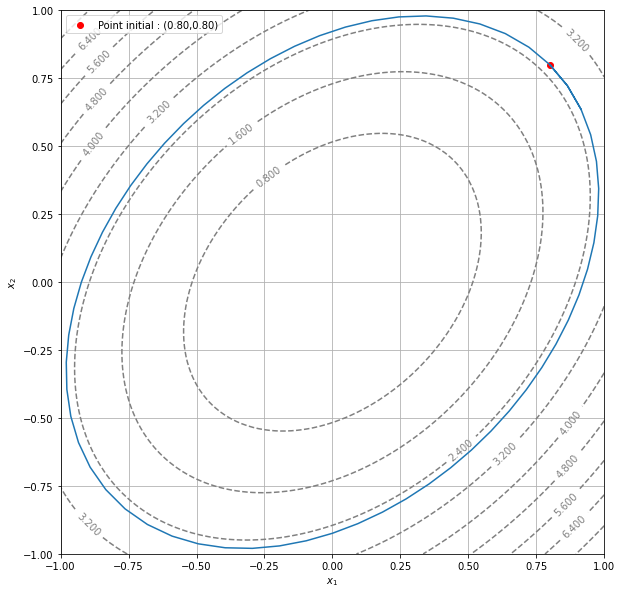

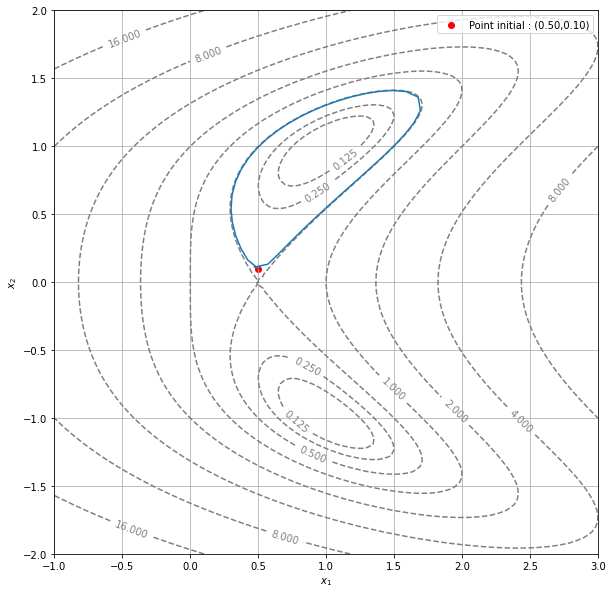

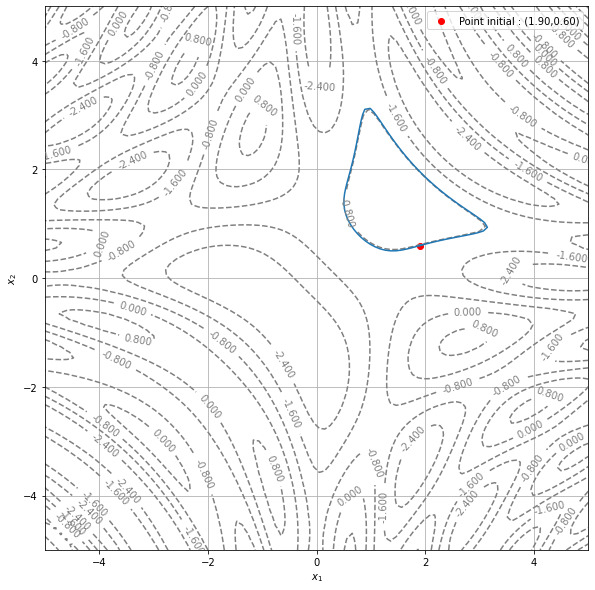

In [50]:
def test_tache5(f1, f2, f3, eps):

    Z1 = level_curve_bis(f1, 0.8, 0.8, 0.1, 1000, eps)
    display_contour(f1, x=np.linspace(-1.0, 1.0, 100), y=np.linspace(-1.0, 1.0, 100), levels=10)
    plt.scatter(np.array(Z1[0][0]), np.array(Z1[1][0]), color = 'red', label = f'Point initial : ({Z1[0][0]:.2f},{Z1[1][0]:.2f})')
    plt.plot(Z1[0], Z1[1])
    plt.legend()

    Z2 = level_curve_bis(f2, 0.5, 0.1, 0.1, 1000, eps)
    display_contour(f2, x=np.linspace(-1.0, 3.0, 100), y=np.linspace(-2.0, 2.0, 100), levels=[2**i for i in range(-3, 8)])
    plt.scatter(np.array(Z2[0][0]), np.array(Z2[1][0]), color = 'red', label = f'Point initial : ({Z2[0][0]:.2f},{Z2[1][0]:.2f})')
    plt.plot(Z2[0], Z2[1])
    plt.legend()

    Z3 = level_curve_bis(f3, 1.9, 0.6, 0.1, 1000, eps)
    display_contour(f3, x=np.linspace(-5.0, 5.0, 100), y=np.linspace(-5.0, 5.0, 100), levels=5)
    plt.scatter(np.array(Z3[0][0]), np.array(Z3[1][0]), color = 'red', label = f'Point initial : ({Z3[0][0]:.2f},{Z3[1][0]:.2f})')
    plt.plot(Z3[0], Z3[1])
    plt.legend()
    plt.show()

test_tache5(f1,f2,f3,eps)

## Post-traitement

Pour améliorer le rendu des courbes de niveau, il est tentant de diminuer la distance $\delta$ entre deux points consécutifs. Malheureusement, dans des cas d'usage réalistes, il est fréquent que la fonction $f$ soit beaucoup plus complexe que les exemples qui nous avons considérés. Le nombre de fois où cette fonction est appelée est alors le principal facteur qui détermine le temps de calcul des lignes de niveau. On cherche donc dans cette section à améliorer la qualité visuelle des résultats sans faire exploser le nombre d'évaluation de la fonction $f$. On va chercher à résoudre ce problème en reliant les points successifs par des chemins plus "flexibles" que des segments de droites, ayant le potentiel de mieux coller aux lignes de niveau.

### Interpolation 

#### Question 8

Soit $P_1$ et $P_2$ deux points du plan et $u_1$ et $u_2$ deux vecteurs du plan non nuls.
On cherche à produire un chemin $\gamma: [0,1] \to \mathbb{R}^2$ continûment différentiable, joignant $P_1$ et $P_2$ ($\gamma(0) = P_1$ et $\gamma(1) = P_2$), tel que $\gamma'(0)$ soit dans la même direction et le même sens que $u_1$ et $\gamma'(1)$ soit dans la même direction et le même sens que $u_2$.

On recherche une telle solution sous la forme
$\gamma(t) = (x(t), y(t))$ où 
$$
x(t) = a + bt + ct^2 \; \mbox{ et } \; y(t) = d + et + ft^2
$$
et les paramètres réels $a, b, c, d, e, f$ sont à déterminer(*).


Déterminer les coefficients $a, b, c, d, e, f$ solutions de ce problème quand ils existent.
Expliciter si nécessaire les conditions que doivent remplir $P_1$, $P_2$, $u_1$ et $u_2$ pour qu'une solution existe.

(*) Cf. ["Mathematical Typography" de Donald E. Knuth](https://projecteuclid.org/euclid.bams/1183544082) pp. 354-359 (Bull. Amer. Math. Soc. (N.S.), Volume 1, Number 2 (1979), 337-372), pour une classe de chemins interpolants similaire mais plus complexe.

**Réponse :**

En utilisant les notations introduites, exprimons les conditions aux points $P_1$ et $P_2$ :
- en $P_1$,   
$\gamma(0) = (a \ , \ d) = P_1$. $(1)$  
$\gamma'(0) = (b \ , \ e) = \lambda_1.u_1$ , où $\lambda_1 \in \mathbb{R^*_+}$. $(2)$
- en $P_2$,  
$\gamma(1) = (a+b+c \ , \ e+d+f) = P_2$. $(3)$  
$\gamma'(1) = (b+2c \ , \ e+2f) = \lambda_2.u_2$, où $\lambda_2 \in \mathbb{R^*_+}$. $(4)$

On voit immédiatement que les valeurs de $a$ et $d$ sont données par le point $P_1$. Puis,   
$(3) - (2) => (b+c \ , \ e+f) = P_2 - P_1$.   
$(2)$ et $(4) => b.u_{12} - e.u_{11} = 0 \ $ et $ \ (b+2c).u_{22} - (e+2f).u_{21} = 0$.

Ce système se traduit sous la forme d'un système matriciel $Y = A.X$, où


$$A = \begin{bmatrix}
1 & 1 & 0 & 0 \\
0 & 0 & 1 & 1 \\
u_{12} & 0 & -u_{11} & 0 \\
u_{22} & 2u_{22} & - u_{21} & -2u_{21}
\end{bmatrix},\ Y = \begin{bmatrix}
p_{21} - p_{11} \\
p_{22} - p_{12} \\
0 \\
0
\end{bmatrix}, \ X = \begin{bmatrix}
b\\
c\\
e\\
f
\end{bmatrix}$$

Ce système admet une solution unique si la matrice $A$ est inversible, i.e. si son déterminant est nul. En développant suivant la première ligne puis suivant les premières colonnes, on obtient : 
$$det(A) = u_{11}.u_{22} - u_{12}.u_{21} = det(u_1,u_2).$$

On en déduit que le système admet une unique solution si et seulement si $u_1$ et $u_2$ forment une famille libre.
On remarquera que cette solution n'est pas forcément celle attendue, car on veut que $(b,e)$ et $(b+2c,e+2f)$ soient respectivement de même sens que $u_1$ et $u_2$.

Dans le cas où $u_1$ et $u_2$ sont liés, il faudrait distinguer les cas suivants qu'ils sont colinéaires de même sens, où de sens contraire, soit quatre cas :   
$--> \ $ et $ \ -->$  
$--> \ $ et $ \ <--$  
$<-- \ $ et $ \ <--$  
$<-- \ $ et $ \ -->$  

 Au vu de l'utilisation que l'on compte en faire, on voit mal d'autre cas que le premier se produire. Une manière de relier les deux points est alors simplement de tracer une droite. 



#### Tâche 6

Implémenter la solution sous la forme d'une fonction `gamma` dont les arguments sont `t`, `P1`, `P2`, `u1` et `u2` et qui renvoie le ou les points $\gamma(t)$ associés. Lorsqu'il n'existe pas de chemin de la forme souhaitée pour les paramètres `P1`, `P2`, `u1` et `u2`, on utilisera comment remplacement de $\gamma$ un chemin rectiligne interpolant linéairement les points $P_1$ et $P_2$.

Pour des raisons de performance, on vectorisera cette fonction par rapport à `t` : 

  - en acceptant comme argument `t` des tableaux NumPy (monodimensionels) de nombres flottants et en renvoyant alors un tableau de taille `(2, len(t))` flottants décrivant l'abscisse et l'ordonnée des `len(t)` points $\gamma(t)$ correspondant,

  - en appliquant directement opérateurs et fonctions mathématiques aux tableaux NumPy, sans utiliser de boucle `for`,
  
On validera ensuite graphiquement l'implémentation sur un exemple où l'on représentera les point $P_1$ et $P_2$, les tangentes associées et le chemin $\gamma$ correspondant.




In [61]:
# On suppose que A est toujours inversible, donc que les vecteurs u1 et u2 ne sont jamais colinéaires
# De plus, on ne prend pas en compte le sens des vecteurs
# Ces deux suppositions n'entravent pas le résultat car les courbes sont suffisamment régulières

def gamma(t, P1, P2, u1, u2):
    A = np.array([[1,        1,         0,       0    ],
                  [0,        0,         1,       1    ],
                  [u1[1],    0,       -u1[0],    0    ],
                  [u2[1],  2*u2[1],  -u2[0],  -2*u2[0]] ])
    X = np.array([P2[0]-P1[0], P2[1]-P1[1], 0, 0])
    Y = np.linalg.solve(A,X)
    a, d = P1
    b, c, e, f = Y
    return np.array([a + b*t + c*t*t, d + e*t + f*t*t])

In [62]:
T = np.linspace(0,1,100)
P1, P2 = [2,4], [-1,2]
u1, u2 = [1,-2], [-2, 1]

None


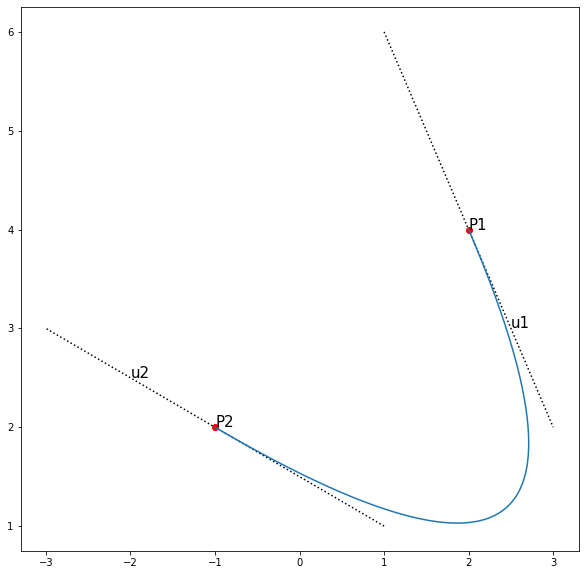

In [63]:
def test_tache6(T, P1, P2, u1, u2):
    Z = gamma(T, P1, P2, u1, u2)
    
    # Affichage de P1 et P2
    plt.scatter(P1[0], P1[1], color = 'red')
    plt.scatter(P2[0], P2[1], color = 'red')
    plt.text(P1[0], P1[1], 'P1', fontsize=15)
    plt.text(P2[0], P2[1], 'P2', fontsize=15)
    
    # Affichage des vecteurs / tangeantes
    plt.text((2*P1[0] + u1[0])/2, (2*P1[1] + u1[1])/2, 'u1', fontsize=15)
    plt.text((2*P2[0] + u2[0])/2, (2*P2[1] + u2[1])/2, 'u2', fontsize=15)
    plt.plot(np.array([P1[0] - u1[0], P1[0] + u1[0]]), 
             np.array([P1[1] - u1[1], P1[1] + u1[1]]), 
             color = 'black', linestyle = ':')
    plt.plot(np.array([P2[0] - u2[0], P2[0] + u2[0]]), 
             np.array([P2[1] - u2[1], P2[1] + u2[1]]), 
             color = 'black', linestyle = ':')
    
    # Affichage de gamma(T)
    plt.plot(Z[0], Z[1])
    return None

print(test_tache6(T, P1, P2, u1, u2))

### Intégration

#### Tâche 7
Intégrer le mécanisme d'interpolation dans (une nouvelle version de) la fonction `level_curve` qui accepte un nouveau paramètre entier `oversampling` (sur-échantillonnage) tel que :

  - si `oversampling == 1`, la fonction `level_curve` fonctionne comme précédemment,

  - si `oversampling > 1`, la fonction `level_curve` introduit dans son résultat `oversampling - 1` points supplémentaires obtenus par interpolations entre chaque couple de points consécutifs obtenus par la méthode de Newton.

In [64]:
def level_curve_ter(f, oversampling, x0, y0, delta=0.1, N=1000, eps=eps):
    
    if oversampling == 1:
        return level_curve_bis(f, x0, y0, delta=0.1, N=1000, eps=eps)
    
    elif oversampling > 1:
        Z = level_curve_bis(f, x0, y0, delta=0.1, N=1000, eps=eps)
        n = len(Z[0])
        X, Y = [], []
        t = np.linspace(0,1,oversampling + 1)
        for i in range(-1, n-2):
            P1, P2 = [Z[0][i+1],Z[1][i+1]], [Z[0][i+2],Z[1][i+2]]
            u1 = [Z[0][i+2]-Z[0][i],Z[1][i+2]-Z[1][i]] 
            u2 = [-Z[0][i+1]+Z[0][(i+3)%n],-Z[1][i+1]+Z[1][(i+3)%n]]
            L = gamma(t, P1, P2, u1, u2)
            X += [L[0][j] for j in range(len(L[0]))]
            Y += [L[1][j] for j in range(len(L[0]))]
        return np.array(X), np.array(Y)

#### Tâche 8

Valider graphiquement le résultat au moyen des exemples de référence.

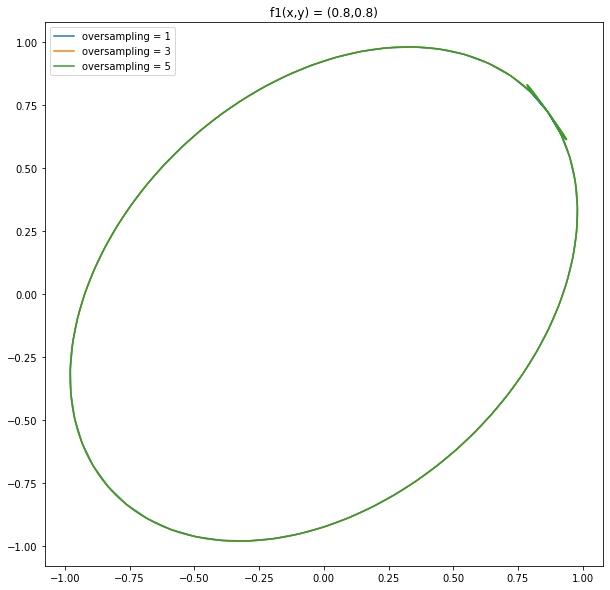

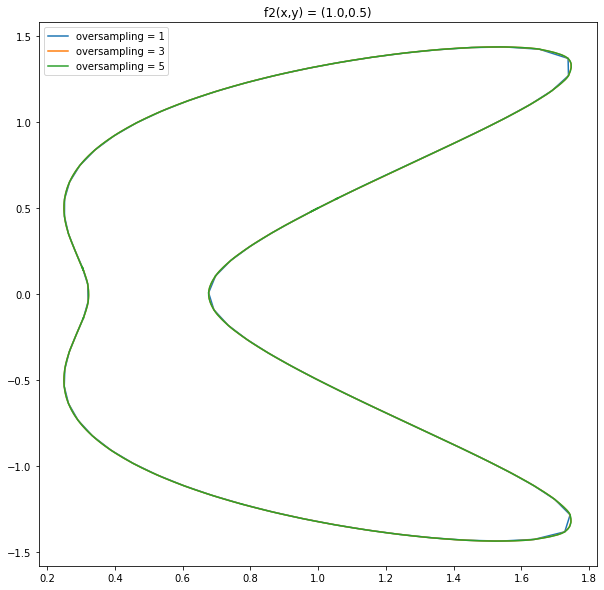

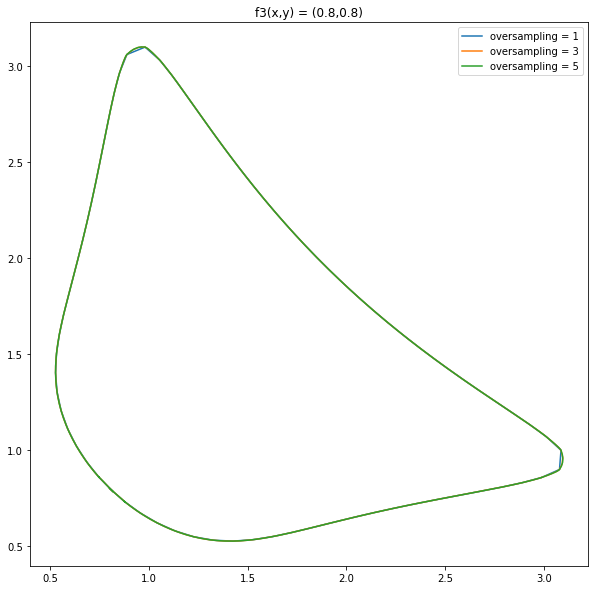

In [65]:
# Il est conseillé de zoomer sur les zones anguleuses pour remarquer la différence des 
# différentes courbes en fonction de "oversampling"

def test_tache8():
    plt.title('f1(x,y) = (0.8,0.8)')
    Z1 = level_curve_ter(f1, 1, 0.8, 0.8, delta=0.1, N=1000, eps=eps)
    Z2 = level_curve_ter(f1, 3, 0.8, 0.8, delta=0.1, N=1000, eps=eps)
    Z3 = level_curve_ter(f1, 5, 0.8, 0.8, delta=0.1, N=1000, eps=eps)
    plt.plot(Z1[0], Z1[1], label='oversampling = 1')
    plt.plot(Z2[0], Z2[1], label='oversampling = 3')
    plt.plot(Z3[0], Z3[1], label='oversampling = 5')
    plt.legend()
    plt.show()

    plt.title('f2(x,y) = (1.0,0.5)')
    Z1 = level_curve_ter(f2, 1, 1.0, 0.5, delta=0.1, N=1000, eps=eps)
    Z2 = level_curve_ter(f2, 3, 1.0, 0.5, delta=0.1, N=1000, eps=eps)
    Z3 = level_curve_ter(f2, 5, 1.0, 0.5, delta=0.1, N=1000, eps=eps)
    plt.plot(Z1[0], Z1[1], label='oversampling = 1')
    plt.plot(Z2[0], Z2[1], label='oversampling = 3')
    plt.plot(Z3[0], Z3[1], label='oversampling = 5')
    plt.legend()
    plt.show()

    plt.title('f3(x,y) = (0.8,0.8)')
    Z1 = level_curve_ter(f3, 1, 0.8, 0.8, delta=0.1, N=1000, eps=eps)
    Z2 = level_curve_ter(f3, 3, 0.8, 0.8, delta=0.1, N=1000, eps=eps)
    Z3 = level_curve_ter(f3, 5, 0.8, 0.8, delta=0.1, N=1000, eps=eps)
    plt.plot(Z1[0], Z1[1], label='oversampling = 1')
    plt.plot(Z2[0], Z2[1], label='oversampling = 3')
    plt.plot(Z3[0], Z3[1], label='oversampling = 5')
    plt.legend()
    plt.show()

test_tache8()